In [10]:
try:
	import google.colab
	IN_COLAB = True
except ImportError:
	IN_COLAB = False

import os
IN_LOCAL = os.getenv("IN_LOCAL")

if IN_COLAB:
	!pip install scikit-learn matplotlib numpy pandas torch pytorch-lightning torchvision tensorboardx tensorflow
elif IN_LOCAL is not None:
	# !cmd doesn't work in docker
	!pip install -r requirements.txt


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pytorch_lightning as pl
from lightning.pytorch import Trainer
#from lightning.pytorch.loggers import WandbLogger

#import wandb
#wandb_api_key = os.getenv("WANDB_API_KEY")

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import random_split, DataLoader
from torchvision import transforms

from IPython.display import display
	# make it not fail in terminal execution
#from typing import override
	# docker is not in python >=3.12

from torchvision import datasets
from torchvision.transforms.v2 import CenterCrop
from sklearn.model_selection import train_test_split

## Hyperparameter configuration, set random states

In [12]:
# hyperparameters
random_state = 42 # random state
test_val_size = 0.2 # size of test and validation together to the whole dataset
test_size = 0.5 # size of test to test and validation together
num_workers = 2 # number of workers for data loading
batch_size = 128
height = 64
width = height

is_celeba_on = True # celebA is needed or not
eval_only = True
visualize_and_analyze = True

In [13]:
# Fix random early on
np.random.seed(random_state)
torch.manual_seed(random_state);

## Data modules

### Custom dataset omitting targets

In [14]:
class NoTargetDataset(torch.utils.data.Dataset):
	def __init__(self, original_dataset):
		super().__init__()
		self.original_dataset = original_dataset

	#@override
	def __len__(self):
		return len(self.original_dataset)

	#@override
	def __getitem__(self, idx):
		image, _ = self.original_dataset[idx]
		return image

### Flowers Module

In [15]:
# Flowers data module
class FlowersDataModule(pl.LightningDataModule):
	def __init__(self, batch_size):
		super().__init__()
		self.name = "Flowers102"
		self.batch_size = batch_size
		self.base_transform = transforms.Compose([
			transforms.CenterCrop(500),
			transforms.Resize(height),
			transforms.ToTensor(),
			transforms.Lambda(lambda img: (img - 0.5) * 2)
		])
		def permutate_last_three(tensor):
			if tensor.ndim == 3:
				return tensor.permute(1, 2, 0)
			assert tensor.ndim == 4
			return tensor.permute(0, 2, 3, 1)
		self.reverse_transform = transforms.Compose([
			transforms.Lambda(lambda img: img / 2 + 0.5),
			transforms.Lambda(lambda img: permutate_last_three(img).numpy() * 255),
			transforms.Lambda(lambda img: img.astype(np.uint8))
		])

		self.dataset_notransform = NoTargetDataset(torch.utils.data.ConcatDataset([
			datasets.Flowers102('./data', download=True, split="train"),
			datasets.Flowers102('./data', download=True, split="test"),
			datasets.Flowers102('./data', download=True, split="val")
		]))
		self.dataset = NoTargetDataset(torch.utils.data.ConcatDataset([
			datasets.Flowers102('./data', download=True, split="train", transform=self.base_transform),
			datasets.Flowers102('./data', download=True, split="test", transform=self.base_transform),
			datasets.Flowers102('./data', download=True, split="val", transform=self.base_transform)
		]))
		self.input_shape = tuple(self.dataset[0].shape)

	#@override
	def setup(self, stage=None):
		train, test_val = train_test_split(self.dataset, test_size=test_val_size, random_state=random_state)
		test, val = train_test_split(test_val, test_size=test_size, random_state=random_state)
		self.train_dataset = train
		self.val_dataset = val
		self.test_dataset = test

	#@override
	def train_dataloader(self):
		return torch.utils.data.DataLoader(
			self.train_dataset,
			batch_size=self.batch_size,
			num_workers=num_workers,
			pin_memory=True,
			drop_last=True,
			shuffle=False,
			persistent_workers=True
				# avoid recreating after every fast epoch
		)

	#@override
	def val_dataloader(self):
		return torch.utils.data.DataLoader(
			self.val_dataset,
			batch_size=self.batch_size,
			num_workers=num_workers,
			pin_memory=True,
			shuffle=False,
			persistent_workers=True
		)

	#@override
	def test_dataloader(self):
		return DataLoader(
			self.test_dataset,
			batch_size=self.batch_size,
			num_workers=num_workers,
			pin_memory=True,
			shuffle=False,
			persistent_workers=True
		)

### CelebA Module

In [16]:
# Celeba data module
class CelebaDataModule(pl.LightningDataModule):
	def __init__(self, batch_size, len_flowers_dataset):
		super().__init__()
		self.name = "CelebA"
		self.batch_size = batch_size
		self.base_transform = transforms.Compose([
			transforms.CenterCrop(178),
			transforms.Resize(height),
			transforms.ToTensor(),
			transforms.Lambda(lambda img: (img - 0.5) * 2)
		])
		def permutate_last_three(tensor):
			if tensor.ndim == 3:
				return tensor.permute(1, 2, 0)
			assert tensor.ndim == 4
			return tensor.permute(0, 2, 3, 1)
		self.reverse_transform = transforms.Compose([
			transforms.Lambda(lambda img: img / 2 + 0.5),
			transforms.Lambda(lambda img: permutate_last_three(img).numpy() * 255),
			transforms.Lambda(lambda img: img.astype(np.uint8))
		])

		# To compare the model on a different dataset it should be the same size (currently 8k vs 200k)
		self.dataset_notransform = NoTargetDataset(torch.utils.data.Subset(
			datasets.CelebA('./data', download=True, split="all"),
			np.random.choice(len_flowers_dataset, len_flowers_dataset, replace=False)
		))
		self.dataset = NoTargetDataset(torch.utils.data.Subset(
			datasets.CelebA('./data', download=True, split="all", transform=self.base_transform),
			np.random.choice(len_flowers_dataset, len_flowers_dataset, replace=False)
		))
		self.input_shape = tuple(self.dataset[0].shape)
	
	#@override
	def setup(self, stage=None):
		train, test_val = train_test_split(self.dataset, test_size=test_val_size, random_state=random_state)
		test, val = train_test_split(test_val, test_size=test_size, random_state=random_state)
		self.train_dataset = train
		self.val_dataset = val
		self.test_dataset = test
	
	#@override
	def train_dataloader(self):
		return torch.utils.data.DataLoader(
			self.train_dataset,
			batch_size=self.batch_size,
			num_workers=num_workers,
			pin_memory=True,
			drop_last=True,
			shuffle=False,
			persistent_workers=True
				# avoid recreating after every fast epoch
		)
	
	#@override
	def val_dataloader(self):
		return torch.utils.data.DataLoader(
			self.val_dataset,
			batch_size=self.batch_size,
			num_workers=num_workers,
			pin_memory=True,
			shuffle=False,
			persistent_workers=True
		)

	#@override
	def test_dataloader(self):
		return DataLoader(
			self.test_dataset,
			batch_size=self.batch_size,
			num_workers=num_workers,
			pin_memory=True,
			shuffle=False,
			persistent_workers=True
		)

## DataModule creation

In [17]:
# Create data module instances
flowers_dm = FlowersDataModule(batch_size)
flowers_dm.prepare_data()
flowers_dm.setup()

if is_celeba_on:
	celeba_dm = CelebaDataModule(batch_size, len(flowers_dm.dataset))
	celeba_dm.prepare_data()
	celeba_dm.setup()

Files already downloaded and verified
Files already downloaded and verified


## Data visualization

In [10]:
# Show sizes of images
def analyze_size(imgs, text, cols=["height", "width", "channels"]):
	sizes = pd.DataFrame([np.array(img).shape for img in imgs])
	sizes.columns = cols
	grouped_df = sizes.groupby(cols).size().reset_index(name='count')
	display(grouped_df.head())
	print(text, "min height", sizes["height"].min())
	print(text, "min width", sizes["width"].min())

if visualize_and_analyze:
	analyze_size(flowers_dm.dataset_notransform, flowers_dm.name)
	if is_celeba_on:
		analyze_size(celeba_dm.dataset_notransform, celeba_dm.name)

,height,width,channels,count
0,500,500,3,70
1,500,501,3,2
2,500,502,3,10
3,500,503,3,10
4,500,504,3,11


Flowers102 min height 500
Flowers102 min width 500


,height,width,channels,count
0,218,178,3,8189


CelebA min height 218
CelebA min width 178


In [19]:
 # Show sizes of transformed images
def analyze_transformed(dataset, text):
	analyze_size(dataset, text, ["channels", "height", "width"])
	images = np.array([np.array(img) for img in dataset])
	return images

if visualize_and_analyze:
	flower_tensors = analyze_transformed(flowers_dm.dataset, flowers_dm.name)
	if is_celeba_on:
		celeba_tensors = analyze_transformed(celeba_dm.dataset, celeba_dm.name)

,channels,height,width,count
0,3,64,64,8189


Flowers102 min height 64
Flowers102 min width 64


,channels,height,width,count
0,3,64,64,8189


CelebA min height 64
CelebA min width 64


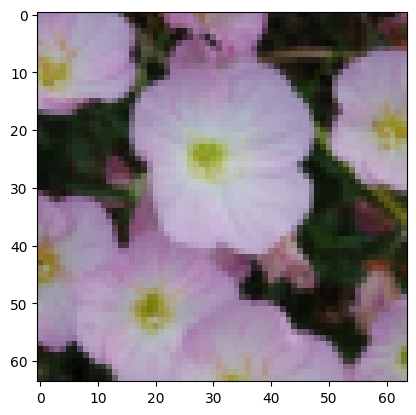

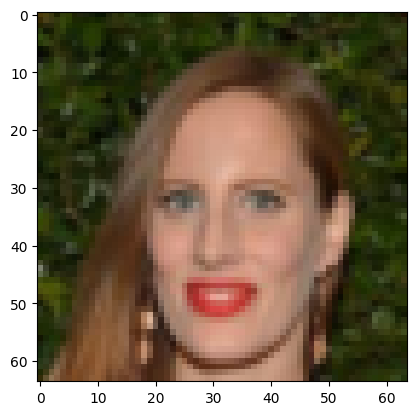

In [20]:
# Transformed image visualization

if visualize_and_analyze:
	plt.imshow(flowers_dm.reverse_transform(flowers_dm.dataset[0]))
	plt.figure()
	if is_celeba_on:
		plt.imshow(celeba_dm.reverse_transform(celeba_dm.dataset[0]))

## Data analysis

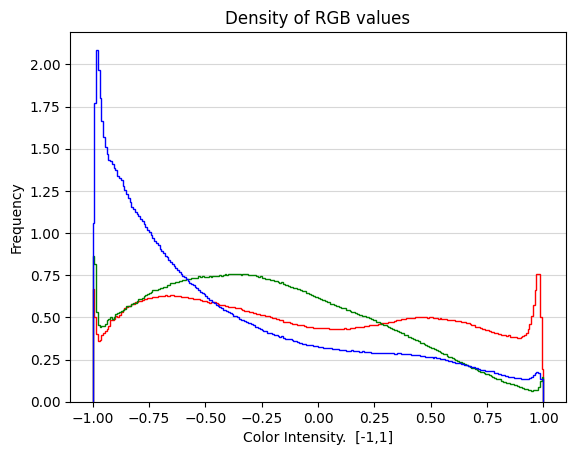

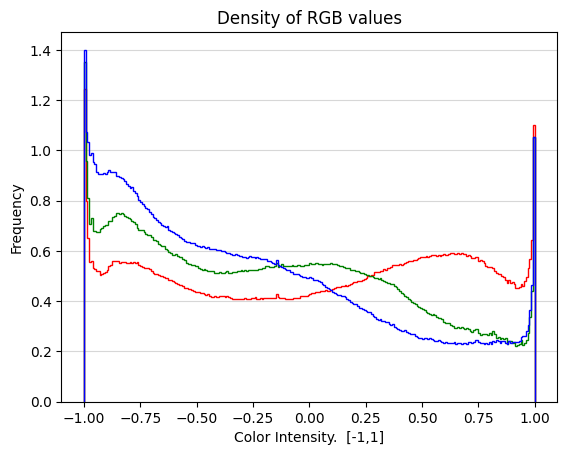

In [21]:
# Distribution of (normalized) pixels
def img_histogram(data):
	for i, color in enumerate(["red", "green", "blue"]):
		plt.hist(data[:, i, :, :].flatten(), bins=256, range=(-1, 1), color=color, histtype=u'step', density=True)
	plt.title('Density of RGB values')
	plt.xlabel('Color Intensity.  [-1,1]')
	plt.ylabel('Frequency')
	plt.grid(axis='y', alpha=0.5)
	plt.show()

if visualize_and_analyze:
	img_histogram(flower_tensors)
	plt.figure()
	if is_celeba_on:
		img_histogram(celeba_tensors)

In [22]:
# split tensor data to train, test, val (only for plot)
def split(dataset):
	train, test = train_test_split(dataset, test_size=test_val_size, random_state=42)
	test, val = train_test_split(test, test_size=test_size, random_state=42)
	print(train.shape)
	print(test.shape)
	print(val.shape)
	return train, test, val

if visualize_and_analyze:
	flower_train, flower_test, flower_val = split(flower_tensors)
	if is_celeba_on:
		celeba_train, celeba_test, celeba_val = split(celeba_tensors)

(6551, 3, 64, 64)
(819, 3, 64, 64)
(819, 3, 64, 64)
(6551, 3, 64, 64)
(819, 3, 64, 64)
(819, 3, 64, 64)


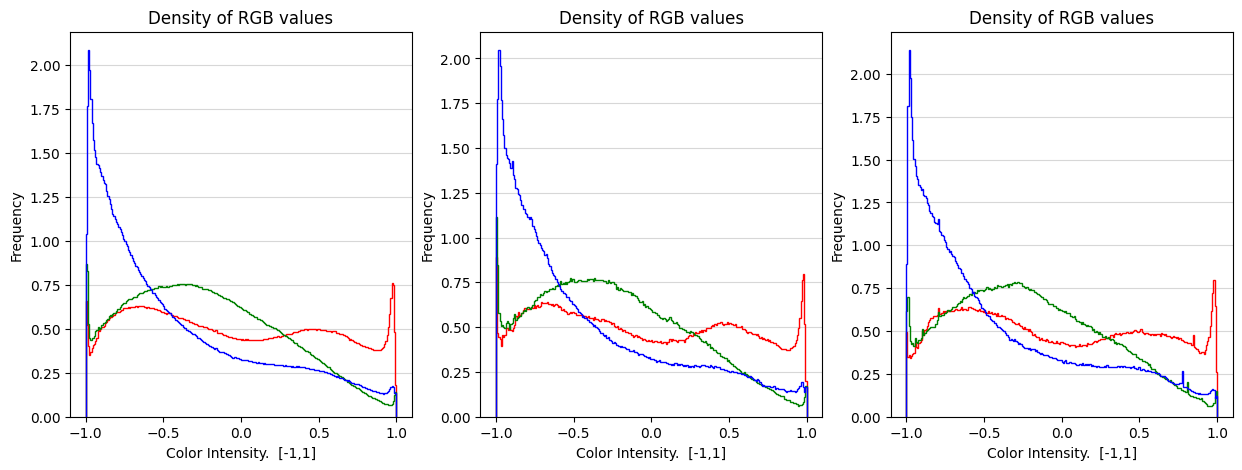

<Figure size 640x480 with 0 Axes>

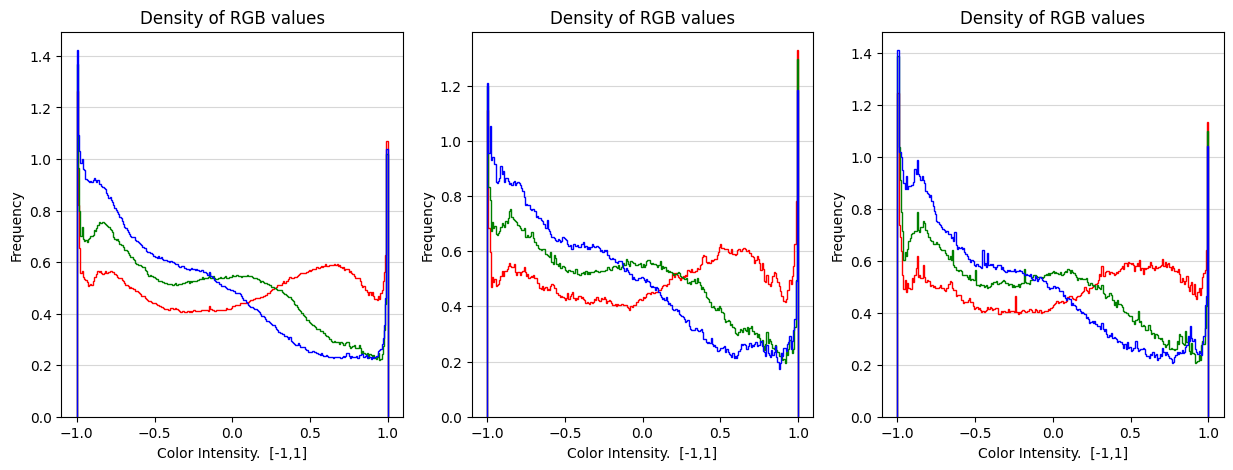

In [23]:
# Check if distribution is similar between train, test, val
def split_histogram(train, test, val):
	fig, axs = plt.subplots(1, 3, figsize=(15, 5))
	for idx, dataset in enumerate([train, test, val]):
		for i, color in enumerate(["red", "green", "blue"]):
			axs[idx].hist(dataset[:, i, :, :].flatten(), bins=256, range=(-1, 1), color=color, histtype=u'step', density=True)
		axs[idx].set_title('Density of RGB values') # can't use existing function because it's not .title 🙃
		axs[idx].set_xlabel('Color Intensity.  [-1,1]') # ...
		axs[idx].set_ylabel('Frequency') # ...
		axs[idx].grid(axis='y', alpha=0.5)
	plt.show()

if visualize_and_analyze:
	split_histogram(flower_train, flower_test, flower_val)
	plt.figure()
	if is_celeba_on:
		split_histogram(celeba_train, celeba_test, celeba_val)

In [24]:
if visualize_and_analyze:
	del flower_tensors
	del flower_train, flower_test, flower_val
	if is_celeba_on:
		del celeba_tensors
		del celeba_train, celeba_test, celeba_val

# Metrics

In [66]:
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore

# Higher is better. The score is calculated on random splits of the images such that both a mean and standard deviation of the score are returned. 
def inception(batch_count, get_images):
	# Calculate inception in batches: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint
	inception_scores = []
	for _ in range(batch_count):
		inception = InceptionScore()
		inception.update(get_images())
		inception_score = inception.compute()

		inception_scores.append(inception_score)
	return torch.tensor(inception_scores).mean(dim=0)

# 0 is the best.
def fid(dm, get_images):
	fid_scores = []
	# Takes too much time for non batch run
	# batch_size can't be large otherwise OOM
	for batch in dm.test_dataloader():
		batch_notransform = torch.from_numpy(dm.reverse_transform(batch)).permute(0, 3, 1, 2)
		
		fid = FrechetInceptionDistance(feature=64)
		fid.update(batch_notransform, real=True)
		fid.update(get_images(), real=False)
		fid_score = fid.compute()

		fid_scores.append(fid_score)
	return torch.tensor(fid_scores).mean(dim=0)

# Baseline

### Random image baseline + metric eval

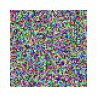

In [ ]:
random_images = torch.randint(0, 255, (3, height, width), dtype=torch.uint8)
plt.figure(figsize=(1, 1))
plt.imshow(random_images.view(height, width, 3))
plt.axis('off');

In [ ]:
inception_score = inception(
	len(flowers_dm.test_dataloader()),
	lambda: torch.randint(0, 255+1, (batch_size, 3, height, width), dtype=torch.uint8)
)
print(f"Inception (mean, std): {inception_score}")

fid_score = fid(
	flowers_dm,
	lambda: torch.randint(0, 255+1, (batch_size, 3, height, width), dtype=torch.uint8)
)
print(f"FID: {fid_score}")


c:\Users\asztr\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


Inception (mean, std): tensor([1.0859, 0.0293])
FID: 281.4394226074219


### Implement and train VAE + metric eval

In [20]:
# https://pytorch-lightning.readthedocs.io/en/0.10.0/lightning_module.html
class VAE(pl.LightningModule):
	def __init__(self, input_shape, latent_size, optimizer_name, learning_rate):
		super().__init__()

		img_channel = input_shape[0]

		# Log hyperparameters
		self.save_hyperparameters()
		self.optimizer_name = optimizer_name
		self.learning_rate = learning_rate
		self.L = latent_size
	
		self.enc = torch.nn.Sequential(
			torch.nn.Conv2d(in_channels=img_channel, out_channels=32, kernel_size=4, stride=2, padding=1),
			torch.nn.ReLU(),

			torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=4, stride=2, padding=1),
			torch.nn.ReLU(),

			torch.nn.Flatten()
		)

		flatten_size = self._shape_after_feature_extraction(input_shape)
		self.mu = torch.nn.Linear(in_features=flatten_size, out_features=self.L)
		self.log_var = torch.nn.Linear(in_features=flatten_size, out_features=self.L)
			# variance can't be negative

		last_conv_size = int(np.sqrt(flatten_size / 32))
		self.dec = torch.nn.Sequential(
			torch.nn.Linear(in_features=self.L, out_features=flatten_size),
			torch.nn.ReLU(),

			torch.nn.Unflatten(dim=1, unflattened_size=(32, last_conv_size, last_conv_size)),
				# dim 1: batches

			torch.nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=4, stride=2, padding=1),
			torch.nn.ReLU(),

			torch.nn.ConvTranspose2d(in_channels=32, out_channels=img_channel, kernel_size=4, stride=2, padding=1),
			# no relu, batchnorm!
			torch.nn.Tanh()
				# Image domain is [-1,1]
		)

	''' Gives the size of flattened layer '''
	def _shape_after_feature_extraction(self, shape):
		batch_size = 1
		input = torch.rand(batch_size, *shape)
		flattened = self.enc(torch.autograd.Variable(input))
		return flattened.data.view(batch_size, -1).size(1)

	def encode(self, x):
		out = self.enc(x)
		mu = self.mu(out)
		lv = self.log_var(out)
		return mu, lv

	def decode(self, z):
		x = self.dec(z)
		return x

	#@override
	def forward(self, x):
		mu, lv = self.encode(x)
		z = mu + torch.randn_like(lv) * torch.exp(lv)
		x_reconstructed = self.decode(z)

		return x_reconstructed, mu, lv

	def any_step(self, batch, batch_idx, phase):
		batch_reconstructed, mu, lv = self(batch)

		KL = torch.sum((mu**2 + torch.exp(lv) - 1 - lv) * .5)
		loss = torch.sum((batch - batch_reconstructed)**2) + KL

		if phase == "train":
			self.log('train_loss', loss, on_step=True, on_epoch=True, logger=True)
		elif phase == "val":
			self.log('val_loss', loss, prog_bar=True)
		else:
			self.log('test_loss', loss, prog_bar=True)

		return loss
		
	#@override
	def training_step(self, batch, batch_idx):
		return self.any_step(batch, batch_idx, "train")
	#@override
	def validation_step(self, batch, batch_idx):
		return self.any_step(batch, batch_idx, "val")
	#@override
	def test_step(self, batch, batch_idx):
		return self.any_step(batch, batch_idx, "test")
	
	#@override
	def configure_optimizers(self):
		if self.optimizer_name == "sgd":
			optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate, momentum=0.9)
		elif self.optimizer_name == "adamw":
			optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate, weight_decay=1e-4)
			optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
		return optimizer

def get_vae(dm, model_name, config):
	import os.path
	if eval_only and os.path.isfile(f"models/{model_name}.ckpt"):
		model = VAE.load_from_checkpoint(f"models/{model_name}.ckpt", batch_size=batch_size)
		model = model.cpu()
	else:	
		model = VAE(dm.input_shape, config.latent_size, config.optimizer_name, config.learning_rate)

		trainer = pl.Trainer(
			max_epochs=config.epoch,
			precision="16-mixed",
			accelerator="gpu",
			devices=1,
			callbacks=[
				pl.callbacks.ModelCheckpoint(monitor="val_loss", save_top_k=1, mode="min", dirpath=f'./models/', filename=model_name),
				pl.callbacks.EarlyStopping(monitor="val_loss", patience=config.early_stop_patience, verbose=False, mode="min")
			],
			#fast_dev_run = True,
			log_every_n_steps=1
		)
		trainer.fit(model, dm)
		trainer.test(dataloaders=dm.test_dataloader())

	model.eval()

	return model
	
from types import SimpleNamespace
	# make dict to class
config = SimpleNamespace(**{
	"latent_size": 2,
	"optimizer_name": "adamw",
	"learning_rate": 0.001,
	"epoch": 200,
	"early_stop_patience": 10,
})

flowers_vae = get_vae(flowers_dm, "vae-flowers", config)
if is_celeba_on:
	#celeba_vae = get_vae(celeba_dm, "vae-celeba", config) # no need to train celeba for baseline
	pass

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
c:\Users\asztr\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory D:\File\Study\BME\Msc\Melytanulas\nhf\models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | enc     | Sequential | 18.0 K | train
1 | mu      | Linear     | 16.4 K | train
2 | log_var | Linear     | 16.4

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\asztr\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at D:\File\Study\BME\Msc\Melytanulas\nhf\models\vae-flowers.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at D:\File\Study\BME\Msc\Melytanulas\nhf\models\vae-flowers.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │         281944.25         │
└───────────────────────────┴───────────────────────────┘

In [21]:
def vae_generate_batch(model, dm, batch_size):
	z_random = torch.randn(batch_size, config.latent_size)
	with torch.no_grad():
		generated_transformed = model.decode(z_random)
		generated = dm.reverse_transform(generated_transformed)
	return generated

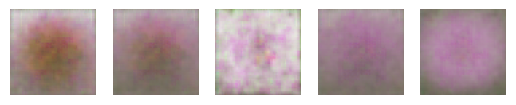

In [22]:
# Generated images from noises
generated = vae_generate_batch(flowers_vae, flowers_dm, 5)

f,ax = plt.subplots(1,5)
for i in range(5):
	ax[i].imshow(generated[i])
	ax[i].axis('off')

In [23]:
inception_score = inception(
	len(flowers_dm.test_dataloader()),
	lambda: torch.from_numpy(vae_generate_batch(flowers_vae, flowers_dm, batch_size)).permute(0, 3, 1, 2)
)
print(f"Inception (mean, std): {inception_score}")

fid_score = fid(
	flowers_dm,
	lambda: torch.from_numpy(vae_generate_batch(flowers_vae, flowers_dm, batch_size)).permute(0, 3, 1, 2)
)
print(f"FID: {fid_score}")

c:\Users\asztr\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


KeyboardInterrupt: 

In [ ]:
# T db gauss zaj hozzáadás: várh érték függ az előző képtől?: https://huggingface.co/blog/annotated-diffusion
# variancia változik minden üzemben (~learning rate schedule)
# lehetne hiperparaméter a beta scheduler is (lineáris, exponenciális)

# Jó levezetés: https://lilianweng.github.io/posts/2021-07-11-diffusion-models/

# ui: https://www.gradio.app/docs/gradio/textbox
# gui: ahol lehet csúszkákat huzogatni (dimenzió értékek) amivel folytonos átmenetet kapunk a generált imagek között